In [1]:
import numpy as np
import csv as csv
import json as js
import matplotlib.pyplot as plt
import pandas_datareader as pd_data
import pickle
import requests
import keras

In [2]:
# Enter your Alpha Vantage API key
api_key = 'XO2YT4XMHPUERBBP'

# Specify the API endpoint and query parameters
url = 'https://www.alphavantage.co/query'
params = {
    'function': 'TIME_SERIES_DAILY_ADJUSTED',
    'symbol': 'IBM',
    'apikey': api_key,
    'outputsize': 'full'
}

# Send the API request and parse the JSON response
response = requests.get(url, params=params)
data_IBM = js.loads(response.text)

In [11]:
daily_data = data_IBM['Time Series (Daily)']
dates = list(daily_data.keys())[:2000][::-1]  # Slice the most recent 600 dates and reverse the order
header = ['Date', '1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume', '7. dividend amount', '8. split coefficient']
rows = []
for date in dates:
    row = [date] + [float(daily_data[date][col]) for col in header[1:]]
    rows.append(row)
# Write the data to a CSV file
with open('data_IBM.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for row in rows:
        writer.writerow(row)


         Date  1. open  2. high  3. low  4. close  5. adjusted close   
0  2015-05-13   171.24   172.74  170.75    172.28         116.544929  \
1  2015-05-14   173.50   174.40  173.22    174.05         117.742309   
2  2015-05-15   173.91   174.41  172.60    173.26         117.207885   
3  2015-05-18   173.44   173.49  172.30    173.06         117.072588   
4  2015-05-19   172.97   173.75  171.93    173.48         117.356712   

   6. volume  7. dividend amount  8. split coefficient  
0  2457521.0                 0.0                   1.0  
1  2438669.0                 0.0                   1.0  
2  2916115.0                 0.0                   1.0  
3  1970630.0                 0.0                   1.0  
4  2523002.0                 0.0                   1.0  
         Date    open    high     low   close  5. adjusted close     volume   
0  2015-05-13  171.24  172.74  170.75  172.28         116.544929  2457521.0  \
1  2015-05-14  173.50  174.40  173.22  174.05         117.742309  2

array([[0.88908006],
       [0.90938289],
       [0.90032117],
       ...,
       [0.339298  ],
       [0.32977747],
       [0.32564808]])

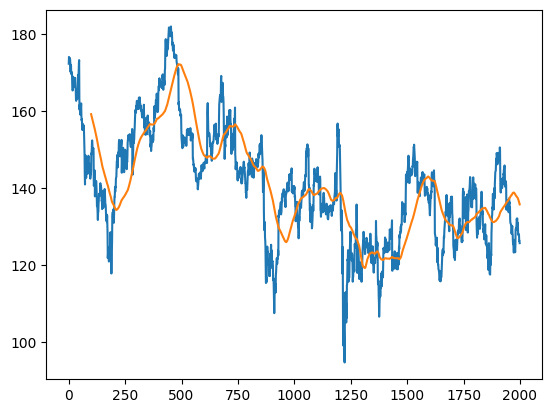

In [12]:
import pandas as pd
# Read CSV file into a pandas DataFrame
df = pd.read_csv('data_IBM.csv')

# Print the first 5 rows of the DataFrame
print(df.head())
df.head()
df = df.rename(columns={'4. close':'close','6. volume':'volume','7. dividend amount':'d_amt','8. split coefficient':'sc'})
df = df.rename(columns={'1. open':'open','2. high':'high','3. low':'low'})
print(df.head())
df = df.drop(['A'])
plt.plot(df.close)
weekma = df.close.rolling(100).mean()
plt.plot(weekma)
data_training = pd.DataFrame(df['close'][0:int(len(df)*0.70)])
data_testing =  pd.DataFrame(df['close'][int(len(df)*0.70):int(len(df))])
print(data_training.shape)
print(data_testing.shape)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_training_array = scaler.fit_transform(data_training)
data_training_array

In [13]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i,0])

In [14]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [16]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1))) 
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True)) 
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True)) 
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu')) 
model.add(Dropout(0.5))

model.add(Dense(units = 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_5 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_6 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
41/41 [==============================] - 34s 435ms/step - loss: 0.0781
Epoch 2/50
41/41 [==============================] - 18s 434ms/step - loss: 0.0195
Epoch 3/50
41/41 [==============================] - 19s 456ms/step - loss: 0.0150
Epoch 4/50
41/41 [==============================] - 18s 438ms/step - loss: 0.0154
Epoch 5/50
41/41 [==============================] - 18s 440ms/step - loss: 0.0136
Epoch 6/50
41/41 [==============================] - 18s 433ms/step - loss: 0.0123
Epoch 7/50
41/41 [==============================] - 18s 437ms/step - loss: 0.0121
Epoch 8/50
41/41 [==============================] - 18s 450ms/step - loss: 0.0108
Epoch 9/50
41/41 [==============================] - 18s 441ms/step - loss: 0.0112
Epoch 10/50
41/41 [==============================] - 18s 434ms/step - loss: 0.0096
Epoch 11/50
41/41 [==============================] - 21s 525ms/step - loss: 0.0094
Epoch 12/50
41/41 [==============================] - 29s 710ms/step - loss: 0.0092
Epoch 13/50
4

In [20]:
model.fit(x_train, y_train, epochs = 150)

Epoch 1/150
41/41 [==============================] - 11s 272ms/step - loss: 0.0038
Epoch 2/150
41/41 [==============================] - 11s 270ms/step - loss: 0.0040
Epoch 3/150
41/41 [==============================] - 11s 272ms/step - loss: 0.0037
Epoch 4/150
41/41 [==============================] - 11s 278ms/step - loss: 0.0039
Epoch 5/150
41/41 [==============================] - 11s 280ms/step - loss: 0.0037
Epoch 6/150
41/41 [==============================] - 11s 271ms/step - loss: 0.0035
Epoch 7/150
41/41 [==============================] - 11s 270ms/step - loss: 0.0038
Epoch 8/150
41/41 [==============================] - 11s 270ms/step - loss: 0.0039
Epoch 9/150
41/41 [==============================] - 11s 272ms/step - loss: 0.0035
Epoch 10/150
41/41 [==============================] - 11s 275ms/step - loss: 0.0034
Epoch 11/150
41/41 [==============================] - 11s 267ms/step - loss: 0.0034
Epoch 12/150
41/41 [==============================] - 11s 270ms/step - loss: 0.0035
E

41/41 [==============================] - 11s 267ms/step - loss: 0.0025
Epoch 99/150
41/41 [==============================] - 11s 262ms/step - loss: 0.0023
Epoch 100/150
41/41 [==============================] - 11s 260ms/step - loss: 0.0023
Epoch 101/150
41/41 [==============================] - 11s 259ms/step - loss: 0.0022
Epoch 102/150
41/41 [==============================] - 11s 261ms/step - loss: 0.0023
Epoch 103/150
41/41 [==============================] - 11s 267ms/step - loss: 0.0022
Epoch 104/150
41/41 [==============================] - 11s 260ms/step - loss: 0.0021
Epoch 105/150
41/41 [==============================] - 11s 260ms/step - loss: 0.0022
Epoch 106/150
41/41 [==============================] - 11s 261ms/step - loss: 0.0021
Epoch 107/150
41/41 [==============================] - 11s 267ms/step - loss: 0.0021
Epoch 108/150
41/41 [==============================] - 11s 267ms/step - loss: 0.0020
Epoch 109/150
41/41 [==============================] - 11s 268ms/step - loss: 0.

In [21]:
model.save('keras_mode.h5')

In [22]:
data_testing.head()

,close
1400,124.62
1401,123.61
1402,127.20
1403,124.70
1404,125.71


In [24]:
print(len(data_testing))

600


In [26]:
data_training.tail(100)

,close
1300,119.20
1301,120.60
1302,123.00
1303,124.01
1304,125.11
...,...
1395,124.42
1396,124.20
1397,124.35
1398,123.52


In [34]:
# here data_training is a data frame
past_100_days = data_training.tail(100) 
final_df = pd.concat([past_100_days,data_testing],ignore_index = True)

In [35]:
final_df.head()

,close
0,119.20
1,120.60
2,123.00
3,124.01
4,125.11


In [39]:
input_data = scaler.fit_transform(final_df)

In [40]:
input_data

array([[0.28120099],
       [0.31257002],
       [0.36634551],
       [0.38897603],
       [0.41362312],
       [0.44185525],
       [0.43490925],
       [0.4933901 ],
       [0.46336545],
       [0.42885951],
       [0.43827022],
       [0.39928299],
       [0.41832848],
       [0.36410486],
       [0.36500112],
       [0.39569796],
       [0.42997983],
       [0.42124132],
       [0.43625364],
       [0.41026216],
       [0.45843603],
       [0.45036971],
       [0.44924938],
       [0.41183061],
       [0.41720816],
       [0.3986108 ],
       [0.4093659 ],
       [0.38516693],
       [0.36970648],
       [0.36993054],
       [0.4263948 ],
       [0.40309209],
       [0.39256106],
       [0.40331616],
       [0.41272687],
       [0.37329151],
       [0.37530809],
       [0.48241093],
       [0.39883486],
       [0.35066099],
       [0.32623796],
       [0.34976473],
       [0.31167376],
       [0.33183957],
       [0.34595564],
       [0.35379789],
       [0.39368138],
       [0.409

In [42]:
input_data.shape


(700, 1)

In [43]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i,0])

In [56]:
x_test,y_test = np.array(x_test),np.array(y_test)

In [57]:
# Making Predicstion
y_predicted =  model.predict(x_test)

19/19 [==============================] - 1s 75ms/step


In [58]:
y_predicted.shape


(600, 1)

In [59]:
y_test

array([0.40264396, 0.38001344, 0.46045261, 0.40443648, 0.427067  ,
       0.45126596, 0.41026216, 0.3948017 , 0.37822093, 0.43199641,
       0.42348196, 0.42348196, 0.4302039 , 0.37508402, 0.38001344,
       0.38651132, 0.40421241, 0.40712525, 0.38427067, 0.39637015,
       0.43087609, 0.38740757, 0.43670177, 0.5072821 , 0.50056016,
       0.49025319, 0.49137352, 0.50548958, 0.4541788 , 0.50011203,
       0.48711629, 0.50123235, 0.5249832 , 0.56016133, 0.26798118,
       0.26730898, 0.35491822, 0.35447009, 0.30091866, 0.27918441,
       0.31122563, 0.28657853, 0.27940847, 0.32198073, 0.3392337 ,
       0.38001344, 0.3461797 , 0.3493166 , 0.31951602, 0.31705131,
       0.3006946 , 0.29845395, 0.31548286, 0.27649563, 0.3183957 ,
       0.31503473, 0.37105086, 0.35447009, 0.27515124, 0.31570692,
       0.30652028, 0.35200538, 0.30159086, 0.36253641, 0.40690119,
       0.39278512, 0.47546493, 0.45910822, 0.46963926, 0.49137352,
       0.48375532, 0.50145642, 0.52453507, 0.49854358, 0.53551

In [60]:
y_predicted

array([[0.3324151 ],
       [0.33782697],
       [0.3431764 ],
       [0.34860566],
       [0.35374206],
       [0.35870257],
       [0.36502266],
       [0.37018764],
       [0.37253335],
       [0.3718081 ],
       [0.37688816],
       [0.38470918],
       [0.39102125],
       [0.39811662],
       [0.39463484],
       [0.38679302],
       [0.38040587],
       [0.38762844],
       [0.40072596],
       [0.4052074 ],
       [0.40970862],
       [0.42712894],
       [0.42987347],
       [0.44111538],
       [0.46127987],
       [0.4810675 ],
       [0.48972046],
       [0.4923858 ],
       [0.49684355],
       [0.48823482],
       [0.4880886 ],
       [0.4868286 ],
       [0.4919598 ],
       [0.50431794],
       [0.52395576],
       [0.49499807],
       [0.43832093],
       [0.39399904],
       [0.36377746],
       [0.3328105 ],
       [0.29937243],
       [0.27484652],
       [0.25537336],
       [0.2408047 ],
       [0.24201357],
       [0.25494486],
       [0.27304018],
       [0.286

In [61]:
scaler.scale_

array([0.02240645])

In [62]:
scale_factor = 1/0.02240645
y_predicted  = y_predicted *  scale_factor
y_test = y_test * scale_factor

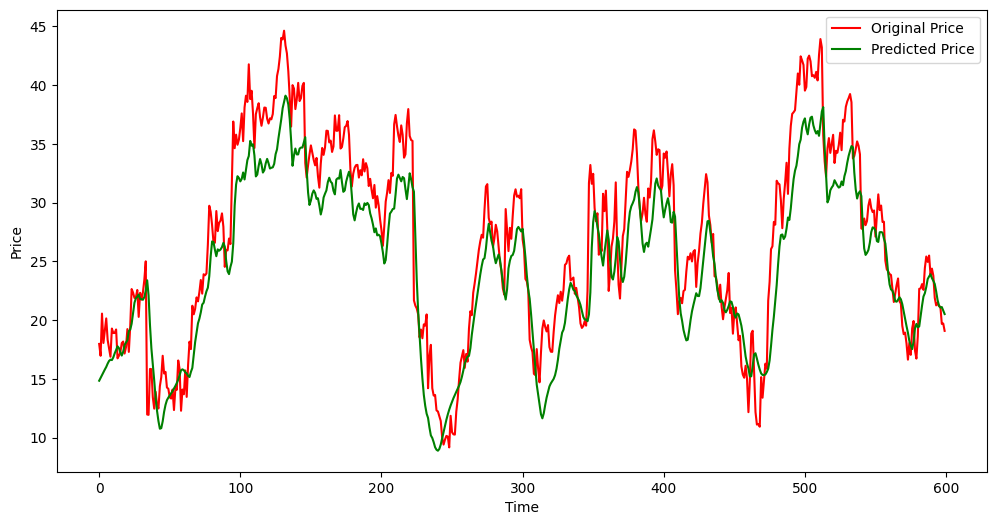

In [63]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'r', label = 'Original Price')
plt.plot(y_predicted, 'g', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()